In [1]:
# set conda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# install psi4
!conda install -q -y psi4 python=3.7 -c psi4

# install rdkit
!conda install -q -y rdkit python=3.7 -c rdkit

# set path
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

# this command is needed to avoid "Loader" error.
!pip install distributed

--2022-04-21 11:40:28--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-04-21 11:40:28--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75660608 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  72.16M   134MB/s    in 0.5s    

2022-04-21 11:40:28 (134 MB/s) - ‘Miniconda3-latest-Linux

In [2]:
# import Psi4
import psi4
# check Psi4 version
print(psi4.__version__)

1.5


In [6]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
# check rdkit version
print('rdkit version: ', rdBase.rdkitVersion)

rdkit version:  2020.09.1


In [7]:
## convert SMILES to xyz format
def smi2xyz(smiles):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    AllChem.EmbedMolecule(mol, AllChem.ETKDGv2())
    AllChem.UFFOptimizeMolecule(mol)
    conf = mol.GetConformer(-1)
    
    xyz = '0 1'
    for atom, (x,y,z) in zip(mol.GetAtoms(), conf.GetPositions()):
        xyz += '\n'
        xyz += '{}\t{}\t{}\t{}'.format(atom.GetSymbol(), x, y, z)
        
    return xyz

In [8]:
psi4.core.set_output_file("log.txt")

psi4.set_memory('10GB')
psi4.set_num_threads(2)

mol = psi4.geometry(smi2xyz('CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O'))

scf_e, wfn = psi4.energy("B3LYP-D3BJ/6-311G(d,p)", return_wfn = True)
print('energy at the {} level of theory:\t{:.4f}'.format("B3LYP-D3BJ/6-311G(d,p)", scf_e))

energy at the B3LYP-D3BJ/6-311G(d,p) level of theory:	-648.8684


In [9]:
psi4.oeprop(wfn, 'WIBERG_LOWDIN_INDICES')
!cat log.txt


  Memory set to   9.313 GiB by Python driver.
  Threads set to 2 by Python driver.

Scratch directory: /tmp/

Scratch directory: /tmp/

*** tstart() called on 96a3046a3c5f
*** at Thu Apr 21 11:54:06 2022

   => Loading Basis Set <=

    Name: 6-311G(D,P)
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2, 4-6, 9-12 entry C          line   113 file /usr/local/share/psi4/basis/6-311g_d_p_.gbs 
    atoms 3, 7-8, 13     entry O          line   151 file /usr/local/share/psi4/basis/6-311g_d_p_.gbs 
    atoms 14-21          entry H          line    32 file /usr/local/share/psi4/basis/6-311g_d_p_.gbs 

   => B3LYP-D3(BJ): Empirical Dispersion <=

    Grimme's -D3 (BJ-damping) Dispersion Correction
    Grimme S.; Ehrlich S.; Goerigk L. (2011), J. Comput. Chem., 32: 1456

        s6 =       1.000000
        s8 =       1.988900
        a1 =       0.398100
        a2 =       4.421100


         ---------------------------------------------------------
                                   SCF
      

In [10]:
import numpy as np
#psi4.oeprop(wfn,'DIPOLE')
dipole_vec = psi4.variable('scf dipole')
dipole = np.sqrt(np.sum(dipole_vec ** 2))
print(f'{dipole:.3f} [D]')

1.253 [D]


In [11]:
level = 'B3LYP-D3BJ/STO-3G' # Mulliken charge
scf_e, wfn = psi4.energy(level, return_wfn = True)

In [12]:
import pandas as pd
df = pd.DataFrame()
psi4.oeprop(wfn, 'MULLIKEN_CHARGES')
df[level] = np.array(wfn.atomic_point_charges())
print (df)

    B3LYP-D3BJ/STO-3G
0           -0.233962
1            0.230235
2           -0.172253
3            0.112126
4           -0.038657
5            0.216389
6           -0.199667
7           -0.241365
8           -0.081375
9           -0.084384
10          -0.073710
11          -0.089993
12          -0.207183
13           0.098135
14           0.102089
15           0.101949
16           0.213237
17           0.079050
18           0.084019
19           0.089132
20           0.096186


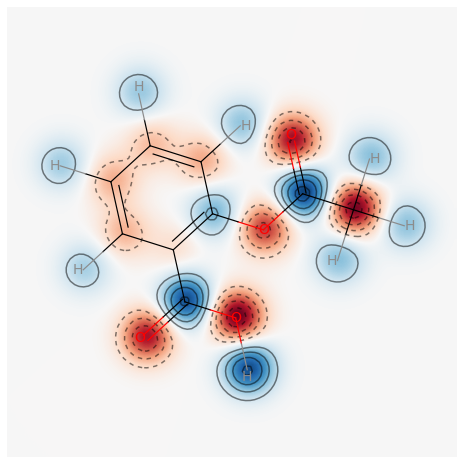

In [13]:
rdkit_aspirin = Chem.AddHs(Chem.MolFromSmiles('CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O'))
mulliken = np.array(wfn.atomic_point_charges())

## Visualization with similarity map
from rdkit.Chem.Draw import SimilarityMaps
fig = SimilarityMaps.GetSimilarityMapFromWeights(rdkit_aspirin, mulliken, colorMap='RdBu')